# gan_image_generation
As part of the data serialization process, we analyze and store metadata on each frame of the film in the dataframes `vision_df` and `face_df`. We've previously used this metadata to copy and shuffle frames that meet a certain criteria, into a new folder. We can use a folder of movie frames featuring a single primary character's face to try and train a GAN.

A GAN, or generative adverserial network, is a pair of two models that work together to create new images that look like the training images. The discriminator resembles an image classification model, while the generator creates images out of random noise. By discriminator trains on the movie frames, learning what they look like, and the generator attempts to create synthetic images to fool the discriminator into thinking they're real. As both models improve, we'll eventually be able to create images that look like the real thing; in this case, movie frames with a single primary character.

This notebook is being run in a Docker notebook using a Tensorflow/Jupyter image, for ease of GPU training.

In [1]:
import tensorflow as tf
tf.__version__

'2.1.0'

Because we're using a pre-built Docker image, we don't have the luxury of easily installing (and keeping) libraries, at least compared to a Conda enviornment. Below, we'll install Pillow, a replace for PIL, which is necessary for displaying images.

In [2]:
# pip install Pillow --user

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from IPython import display

### Loading a single image
First, we'll look at a single image. We'll downscale it to 192x80.

In [4]:
frame_folder = '../filtered_data/primary_character/positive/'
frame = 'booksmart_2019_frame_57.jpg'

In [5]:
size = (80, 192)

In [6]:
frame_pil = load_img(frame_folder + frame, color_mode = 'grayscale', target_size=size)
type(frame_pil)

PIL.Image.Image

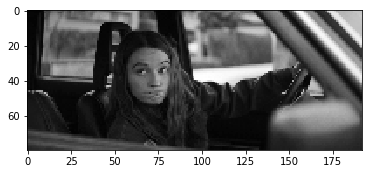

In [7]:
plt.imshow(frame_pil, cmap='gray')

In [8]:
frame_array = img_to_array(frame_pil)
type(frame_array)

numpy.ndarray

In [9]:
frame_array.shape

(80, 192, 1)

In [10]:
frame_array = frame_array.reshape((80, 192))
frame_array.shape

(80, 192)

### Load all images
Next, we'll load all images. We'll compile all of the frames' PIL.Image data in a list, and then convert that into a NumPy array ready for processing.

In [11]:
train_images_list = []
for frame in os.listdir(frame_folder):
    frame_pil = load_img(frame_folder + frame, color_mode = 'grayscale', target_size=size)
    frame_array = img_to_array(frame_pil)
    frame_array = frame_array.reshape((80, 192))
    train_images_list.append(frame_array)
    
len(train_images_list)

12541

In [12]:
train_images = np.asarray(train_images_list)

In [13]:
train_images.shape

(12541, 80, 192)

In [14]:
train_images = train_images.reshape(train_images.shape[0], 80, 192, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [15]:
BUFFER_SIZE = len(train_images_list)
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Defining models and loss
Next, we'll define the models and their loss functions, so we can control the training. Through each subsequent layer, the generator will "upscale" noise, hopefully in the shape of a movie frame.

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(20*48*256, use_bias=False, input_shape=(256,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((20, 48, 256)))
    assert model.output_shape == (None, 20, 48, 256)

    model.add(layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False))
    assert model.output_shape == (None, 20, 48, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False))
    assert model.output_shape == (None, 40, 96, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 80, 192, 1)

    return model

In [17]:
generator = make_generator_model()

The generator starts with random noise. Here's an example of the generator creating an image, before it's been properly trained.

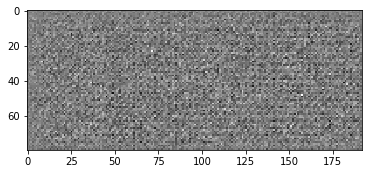

In [18]:
noise = tf.random.normal([1, 256])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

The discriminator resembles a CNN image classifier, deciding yes this looks real, or no this looks fake.

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, 5, strides=2, padding='same', input_shape=[80, 192, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 5, strides=2, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

It outputs a negative decision value if it doesn't think it's looking at a real image, and a positive value if it does.

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00118756]], shape=(1, 1), dtype=float32)


We'll also define loss functions, with the overall goal of training the generator and discriminator at the same pace.

In [21]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)